D:\Storage\Repositories\wiosym\data_raw\glo\env\ocean\cmems\byq2303302024

# Overview

The GLORYS12V1 product is the CMEMS global ocean eddy-resolving (1/12° horizontal resolution, 50 vertical levels) reanalysis covering the altimetry (1993 onward).

It is based largely on the current real-time global forecasting CMEMS system. The model component is the NEMO platform driven at surface by ECMWF ERA-Interim then ERA5 reanalyses for recent years. Observations are assimilated by means of a reduced-order Kalman filter. Along track altimeter data (Sea Level Anomaly), Satellite Sea Surface Temperature, Sea Ice Concentration and In situ Temperature and Salinity vertical Profiles are jointly assimilated. Moreover, a 3D-VAR scheme provides a correction for the slowly-evolving large-scale biases in temperature and salinity.

This product includes daily and monthly mean files for temperature, salinity, currents, sea level, mixed layer depth and ice parameters from the top to the bottom. The global ocean output files are displayed on a standard regular grid at 1/12° (approximatively 8 km) and on 50 standard levels.

DOI (product): https://doi.org/10.48670/moi-00021

Sea water potential temperature (T)
Sea water potential temperature at sea floor (bottomT)

# Import necessary packages

In [1]:
# File system
import os, gc

# Computation and plotting
import numpy as np
from scipy.interpolate import griddata, interp1d

import matplotlib.pyplot as plt
import cmocean.cm as cmo

# Query from CMEMS
import motuclient

# NetCDF and geotiff functionality
import xarray as xr
import rioxarray as rxr
from pyproj import Proj, Transformer, CRS

# Data settings and boundaries

In [2]:
# WIOSYM area bounded by:
# Lat 42° S, 18° N
# Long 6° E, 80° E
lat_north = 18.56
lat_south = -42.5
lon_west = 5.5
lon_east = 80.5

username = 'bqueste1'
password = '@nrIm10liv@'


In [3]:
import requests
session = requests.Session()
session.auth = (username, password)

store = xr.backends.PydapDataStore.open('https://my.cmems-du.eu/thredds/dodsC/cmems_mod_glo_phy_my_0.083_P1M-m',
                                        session=session)
data = xr.open_dataset(store)
data

<xarray.Dataset>
Dimensions:    (longitude: 4320, latitude: 2041, depth: 50, time: 336)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * latitude   (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * time       (time) datetime64[ns] 1993-01-16T12:00:00 ... 2020-12-16T12:00:00
Data variables:
    mlotst     (time, latitude, longitude) float32 ...
    zos        (time, latitude, longitude) float32 ...
    bottomT    (time, latitude, longitude) float32 ...
    sithick    (time, latitude, longitude) float32 ...
    siconc     (time, latitude, longitude) float32 ...
    usi        (time, latitude, longitude) float32 ...
    vsi        (time, latitude, longitude) float32 ...
    thetao     (time, depth, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
Attributes: (12/14)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    area:                          GLOBAL
    product:                       GLOBAL_REANALYSIS_001_030
    dataset:                       global-reanalysis-001-030-monthly
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...

# Load WIOSYM grid coordinates

In [4]:
# Open masked grid file
grid1km = rxr.open_rasterio('../grid_1km_v01.1.tif',
                                 masked=True)
# Create coordinate grid
grid_lon, grid_lat = np.meshgrid(grid1km.x.values,grid1km.y.values)
crs = CRS.from_proj4(grid1km.rio.crs.to_proj4())
proj = Transformer.from_crs(crs, crs.geodetic_crs)

# Remap to prohection
grid_lon, grid_lat = proj.transform(grid_lon,grid_lat)

### Load downloaded data and assemble climatologies / perform averaging

In [7]:
lat_idx = (data.latitude > lat_south) & (data.latitude < lat_north)
lon_idx = (data.longitude < lon_east) & (data.longitude > lon_west)

years = np.arange(2011,2016)
sum_downloads = []
for year in years:
    for month in np.arange(12):
        dt = np.datetime64(str(year))
        time_idx = (data.time >= dt+np.timedelta64(month,'M')) & (data.time < dt+np.timedelta64(month+1,'M'))

        data.thetao.isel(latitude=lat_idx, longitude=lon_idx, depth=0, time=time_idx).mean(dim='time').to_netcdf(path='SST_'+str(year)+'_'+str(month+1)+'.nc')

In [10]:
data.close()

data = xr.open_mfdataset('SST_*.nc',concat_dim='time', combine='nested')

out = data.mean(dim='time')

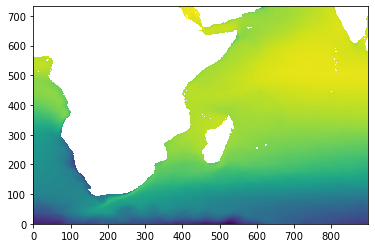

In [13]:
plt.pcolormesh(out.thetao)

### Remove edge effects due to issues with varying coastlines between raw and grid

In [17]:
from scipy.interpolate import NearestNDInterpolator
data = out.thetao.values
mask = np.where(~np.isnan(data))
interp = NearestNDInterpolator(np.transpose(mask), data[mask])
filled_data = interp(*np.indices(data.shape))

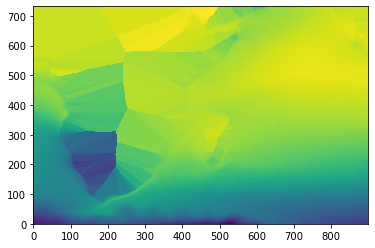

In [18]:
plt.pcolormesh(filled_data)

## Start gridding

In [19]:
lons, lats = np.meshgrid(out.longitude.values,out.latitude.values) 

In [20]:
raster = griddata((lons.flatten(), lats.flatten()), filled_data.flatten(), (grid_lon, grid_lat))

### Save

In [21]:
grid1km = grid1km.mean('band')

In [22]:
grid1km.values = (grid1km.values*0 + raster)*1000
grid1km.attrs['scale_factor'] = 1000
grid1km.rio.to_raster("grid_1km_SST_byq.tif",dtype='float64')

### Visualise

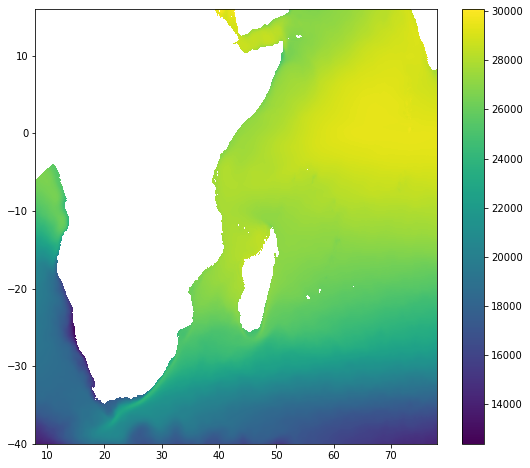

In [23]:
plt.figure(figsize=(9,8))
plt.pcolormesh(grid_lon, grid_lat, grid1km.values, shading='auto')
plt.colorbar()